## Задание

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-06-13 по 2022-06-19 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 
1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy import stats
import hashlib

In [2]:
%matplotlib inline
rc = {
    'figure.figsize': (10, 6)
}
sns.set(rc=rc, style='whitegrid')

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220720'
}

In [4]:
# Загружаем все необходимые данные
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-06-13' and '2022-06-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(query, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [6]:
# Размер групп примерно одинаковый
df.exp_group.value_counts()

1    10079
2     9952
Name: exp_group, dtype: int64

Text(0.5, 0, 'CTR')

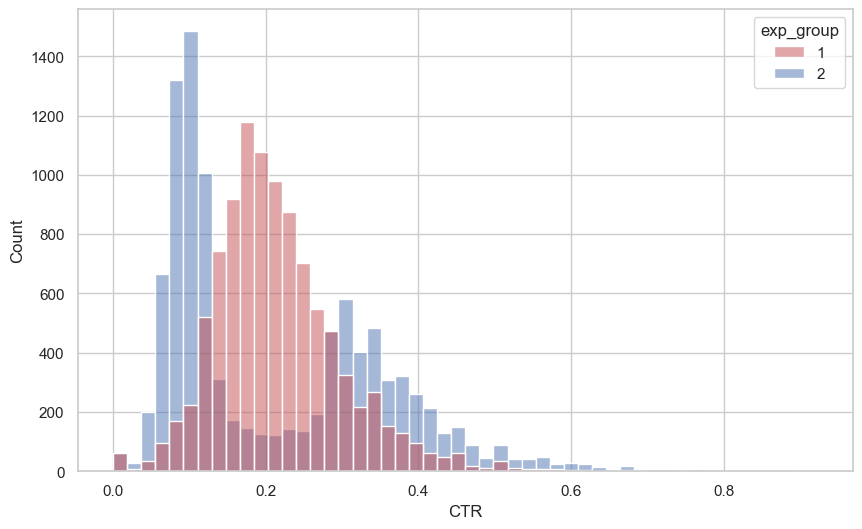

In [7]:
# Визуализируем распределение CTR двух групп
chart = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              bins=50)
chart.set_xlabel('CTR')

График показывает, что распределения CTR-ов в двух группах отличаются. В контрольной группе оно унимодальное, в тестовой - бимодальное. Уже это говорит нам о том, что сравнение CTR-ов не даст нам каких-то обаснованных однозначных выводов о том, стоит ли использовать новый алгоритм рекомендации постов

### t-тест и тест Манна-Уитни на обычных данных

In [8]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False).pvalue

0.4780623130874935

In [9]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided').pvalue

6.0376484617779035e-56

Тест Манна-Уитни показал, что средние отличаются. Как именно - неизвестно. t-тест показал высокий p-value, на основе которого нам придётся принять гипотезу о равенстве средних. Однако мы видели распределение CTR-ов и полагаться на этот результат было бы неправильно

### Сглаженный CTR

In [10]:
def smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [11]:
global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

In [12]:
smothed_ctr_1 = df[df.exp_group == 1].apply(lambda x: smothed_ctr(x.likes, x.views, global_ctr_1, 5), axis=1)
smothed_ctr_2 = df[df.exp_group == 2].apply(lambda x: smothed_ctr(x.likes, x.views, global_ctr_2, 5), axis=1)

Text(0.5, 0, 'smothed CTR')

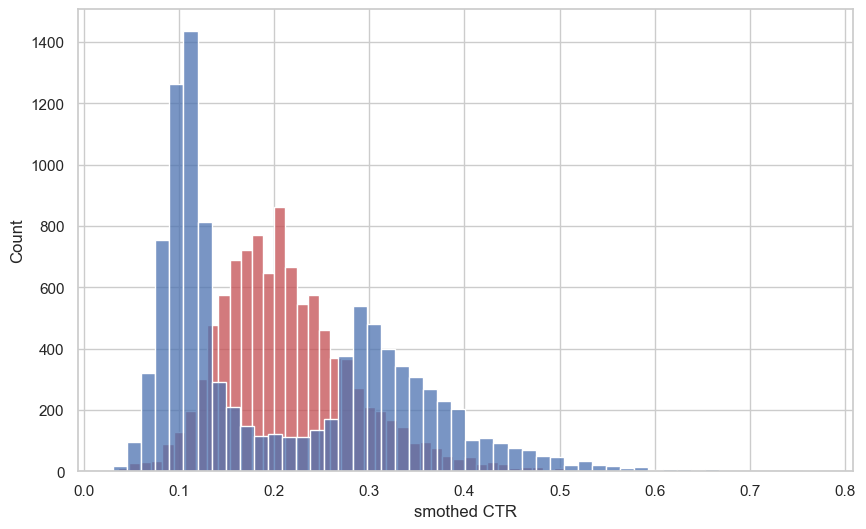

In [13]:
chart_1 = sns.histplot(smothed_ctr_1, color='r', bins=50)
chart_2 = sns.histplot(smothed_ctr_2, color='b', bins=50)
chart_1.set_xlabel('smothed CTR')

In [14]:
stats.ttest_ind(smothed_ctr_1,
                smothed_ctr_2,
                equal_var=False).pvalue

0.022376981555855876

In [15]:
stats.mannwhitneyu(smothed_ctr_1,
                   smothed_ctr_2, 
                   alternative = 'two-sided').pvalue

1.6163964114270227e-61

Тест Манна-Уитни по-прежнему говорит о различии средних. Однако теперь t-тест также это утверждает. Скорее всего, на это повиляло визуально заметное сглаживание CTR контрольной группы и правого "горба" тестовой группы

### Пуассоновский бутстреп

In [16]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [17]:
globalCTR1, globalCTR2 = bootstrap(
                            df[df.exp_group == 1].likes.to_numpy(),
                            df[df.exp_group == 1].views.to_numpy(),
                            df[df.exp_group == 2].likes.to_numpy(),
                            df[df.exp_group == 2].views.to_numpy(),
                            n_bootstrap = 1000)

<AxesSubplot:ylabel='Count'>

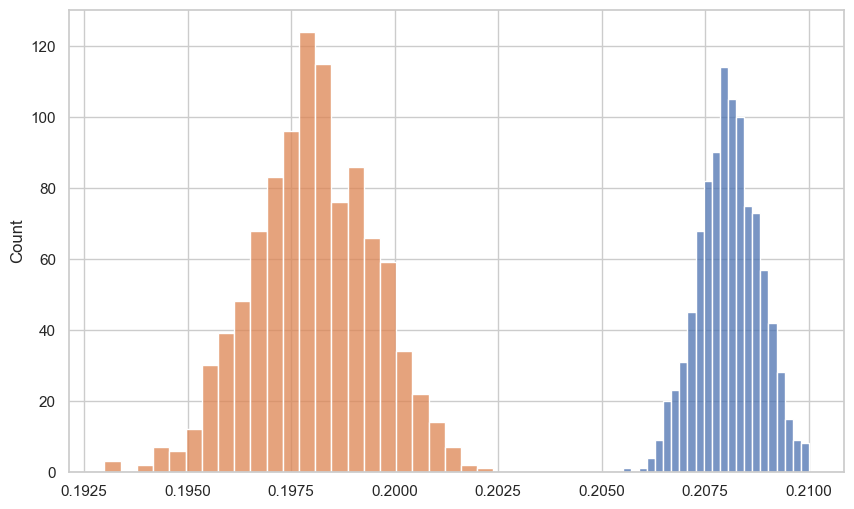

In [18]:
sns.histplot(globalCTR1)
sns.histplot(globalCTR2)

<AxesSubplot:ylabel='Count'>

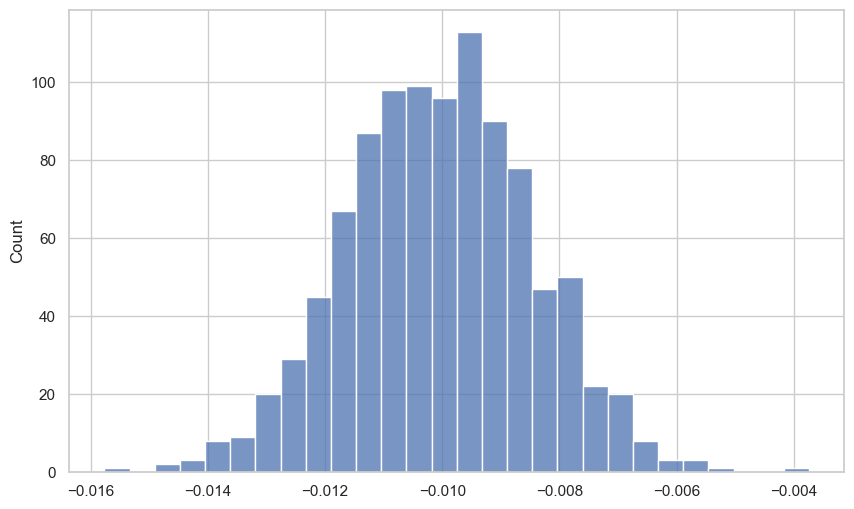

In [19]:
sns.histplot(globalCTR2 - globalCTR1)

Пуассоновский бутстреп говорит об однозначном отличии средних CTR-ов тестовой и контрольной групп. Также согласно этому исследованию средний CTR контрольной группы выше CTR тестовой

### Бакетное преобразование

In [20]:
# Загружаем данные по бакетам
query = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-06-13' and '2022-06-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket_df = ph.read_clickhouse(query, connection=connection)

In [21]:
bucket_df.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


Text(0.5, 0, 'bucket CTR of group 1')

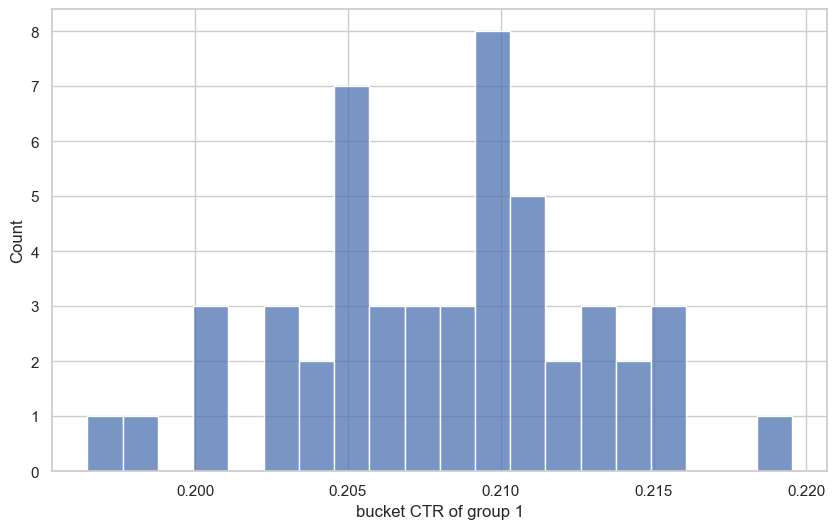

In [22]:
chart = sns.histplot(bucket_df[bucket_df.exp_group == 1].bucket_ctr, bins=20)
chart.set_xlabel('bucket CTR of group 1')

Text(0.5, 0, 'bucket CTR of group 2')

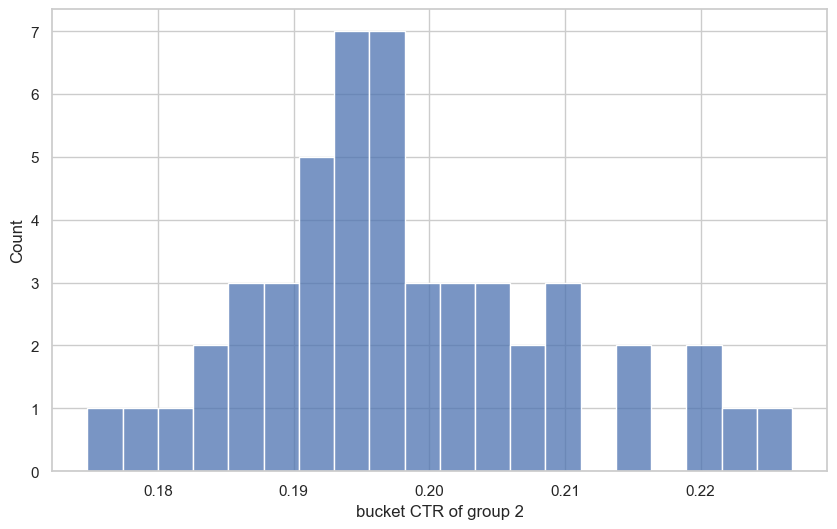

In [23]:
chart = sns.histplot(bucket_df[bucket_df.exp_group == 2].bucket_ctr, bins=20)
chart.set_xlabel('bucket CTR of group 2')

In [24]:
stats.ttest_ind(bucket_df[bucket_df.exp_group == 1].bucket_ctr,
                bucket_df[bucket_df.exp_group == 2].bucket_ctr,
                equal_var=False).pvalue

3.4455951649945907e-07

In [25]:
stats.mannwhitneyu(bucket_df[bucket_df.exp_group == 1].bucket_ctr,
                   bucket_df[bucket_df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided').pvalue

2.859963936492646e-07

Оба теста с предварительным бакетным преобразованием выявили различие средних двух групп

### Вывод

Все тесты кроме t-теста на непредобработанных данных засекли различия между средними двух групп. А если взглянуть, как расределены средние подвыборок бутстрепа и CTR бакетов, то можно заметить, что в среднем нововведение лишь понизило CTR. Так что не стоит распроатрнять работу нового рекомендационного алгоритма на всех пользователей. Но главное, что новый алгоритм двояко повлиял на пользователей. Часть из них (меньшая) стала чаше лайкать посты, а другая (большая) - наоборот меньше. Эти две группы заметны на графике распределения и их стоит исследовать и понять, какими общими свойствами обладают пользователи отдельных групп. Осознав, что определяет пользователей, которые стали реже лайкать посты, можно будет задуматься о том, возможно ли повысить их CTR, не уронив при этом CTR других пользователей, и если да то как. А затем, возможно, провести ещё один эксперимент